<a href="https://colab.research.google.com/github/Elnabrees/Parallel-Computing/blob/main/titanic_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading and Reading the dataset

In [39]:
from google.colab import files
import zipfile
import os
import pandas as pd

# Upload the file
uploaded = files.upload()

# Path to the uploaded zip file
zip_path = '/content/titanic (1).zip'

# Unzipping the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/titanic_data/')

# List all files in the extracted folder
extracted_files = os.listdir('/content/titanic_data/')
print("Extracted files:", extracted_files)

# Assuming the extracted CSV file is named 'train.csv' (change the name if needed)
csv_file_path = '/content/titanic_data/train.csv'  # Update the file name if needed

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file_path)

# Display the first few rows of the dataframe
df.head()


Saving titanic.zip to titanic (5).zip
Extracted files: ['train.csv', 'gender_submission.csv', 'test.csv']


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Titanic Dataset - Classification Pipeline


#  5.2 Experimental Setup + feature engineering
In this section, we'll set up our experimental framework and implement advanced feature engineering techniques to improve model performance. Our goal is to achieve an accuracy greater than 84% on the Titanic survival prediction task.

# 5.3 Performance Measures We will use:

Accuracy: The proportion of correct predictions among the total number of predictions
Classification Report: Provides precision, recall, and F1-score for each class
Confusion Matrix: Visualizes true positives, false positives, true negatives, and false negatives

In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv("/content/titanic_data/train.csv")

# Advanced Feature Engineering
def advanced_feature_engineering(df):
    df_processed = df.copy()

    # Family size & Alone
    df_processed['FamilySize'] = df_processed['SibSp'] + df_processed['Parch'] + 1
    df_processed['IsAlone'] = (df_processed['FamilySize'] == 1).astype(int)

    # Extract and simplify titles
    df_processed['Title'] = df_processed['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    title_map = {
        "Mr": "Mr", "Miss": "Miss", "Mrs": "Mrs", "Master": "Master",
        "Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs",
        "Dr": "Rare", "Rev": "Rare", "Col": "Rare", "Major": "Rare",
        "Countess": "Rare", "Lady": "Rare", "Jonkheer": "Rare",
        "Don": "Rare", "Dona": "Rare", "Capt": "Rare", "Sir": "Rare"
    }
    df_processed['Title'] = df_processed['Title'].map(lambda x: title_map.get(x, "Rare"))

    # Fill missing values
    df_processed['Age'] = df_processed.groupby('Title')['Age'].transform(lambda x: x.fillna(x.median()))
    df_processed['Fare'] = df_processed.groupby('Pclass')['Fare'].transform(lambda x: x.fillna(x.median()))
    df_processed['Embarked'] = df_processed['Embarked'].fillna(df_processed['Embarked'].mode()[0])

    # Bin Age and Fare
    df_processed['AgeBin'] = pd.cut(df_processed['Age'], bins=[0, 12, 20, 40, 60, 100], labels=[0, 1, 2, 3, 4])
    df_processed['FareBin'] = pd.qcut(df_processed['Fare'], 6, labels=False)

    # Encode categorical features
    le = LabelEncoder()
    df_processed['Sex'] = le.fit_transform(df_processed['Sex'])
    df_processed['Embarked'] = le.fit_transform(df_processed['Embarked'])

    # Interaction & composite features
    df_processed['Sex_Pclass'] = df_processed['Sex'] * df_processed['Pclass']
    df_processed['Age_Pclass'] = df_processed['Age'] * df_processed['Pclass']
    df_processed['Fare_Per_Person'] = df_processed['Fare'] / df_processed['FamilySize']
    df_processed['Age_Class_Fare'] = df_processed['Age'] * df_processed['Pclass'] * df_processed['Fare']
    df_processed['Fare_log'] = np.log1p(df_processed['Fare'])
    df_processed['Age_log'] = np.log1p(df_processed['Age'])
    df_processed['Family_Survival'] = df_processed['FamilySize'] * df_processed['Survived'].mean()

    # Cabin features
    df_processed['Has_Cabin'] = df_processed['Cabin'].notnull().astype(int)
    df_processed['Cabin_Letter'] = df_processed['Cabin'].str[0].fillna('U')

    # One-hot encode titles, pclass, cabin letters
    df_processed = pd.get_dummies(df_processed, columns=['Title', 'Pclass', 'Cabin_Letter'], drop_first=True)

    # Drop unused columns
    df_processed.drop(columns=['Name', 'Ticket', 'Cabin', 'PassengerId'], inplace=True)

    return df_processed

# Process data
df_processed = advanced_feature_engineering(df)

# Define features and target
X = df_processed.drop(columns=['Survived'])
y = df_processed['Survived']
feature_names = X.columns  # Save column names before scaling

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Feature Selection
def select_features(X, y, feature_names):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)

    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]

    print("Feature ranking:")
    for i in range(min(20, len(feature_names))):
        print(f"{i+1}. {feature_names[indices[i]]} ({importances[indices[i]]:.5f})")

    selector = SelectFromModel(rf, threshold="median", prefit=True)
    X_selected = selector.transform(X)

    selected_indices = selector.get_support(indices=True)
    selected_features = [feature_names[i] for i in selected_indices]
    print(f"\nSelected features: {selected_features}")

    return X_selected, selected_indices

# Apply feature selection
X_selected, selected_indices = select_features(X_scaled, y, feature_names)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, stratify=y, random_state=42)


Feature ranking:
1. Sex (0.09314)
2. Age_Pclass (0.08143)
3. Age_Class_Fare (0.08061)
4. Fare_Per_Person (0.07837)
5. Title_Mr (0.07437)
6. Sex_Pclass (0.07313)
7. Fare (0.06886)
8. Fare_log (0.06098)
9. Age_log (0.06049)
10. Age (0.05877)
11. Family_Survival (0.02910)
12. Title_Miss (0.02788)
13. Pclass_3 (0.02712)
14. Title_Mrs (0.02584)
15. FamilySize (0.02320)
16. FareBin (0.02298)
17. Embarked (0.01676)
18. Has_Cabin (0.01439)
19. AgeBin (0.01342)
20. SibSp (0.01311)

Selected features: ['Sex', 'Age', 'Fare', 'FamilySize', 'FareBin', 'Sex_Pclass', 'Age_Pclass', 'Fare_Per_Person', 'Age_Class_Fare', 'Fare_log', 'Age_log', 'Family_Survival', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Pclass_3']


## 5.4 Optimization Strategy

To achieve an accuracy greater than 84%, we'll implement a comprehensive optimization strategy that includes:

1. **Advanced Feature Engineering**: Creating meaningful features that capture complex relationships in the data
2. **Feature Selection**: Identifying and using only the most predictive features
3. **Model Ensemble**: Combining multiple models to improve prediction accuracy
4. **Hyperparameter Tuning**: Finding optimal parameters for each model
5. **Cross-Validation**: Ensuring our models generalize well to unseen data

We'll implement several state-of-the-art models and ensemble techniques to maximize our prediction accuracy.


Training Random Forest...
Random Forest Accuracy: 0.8212
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.86       110
           1       0.78      0.74      0.76        69

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



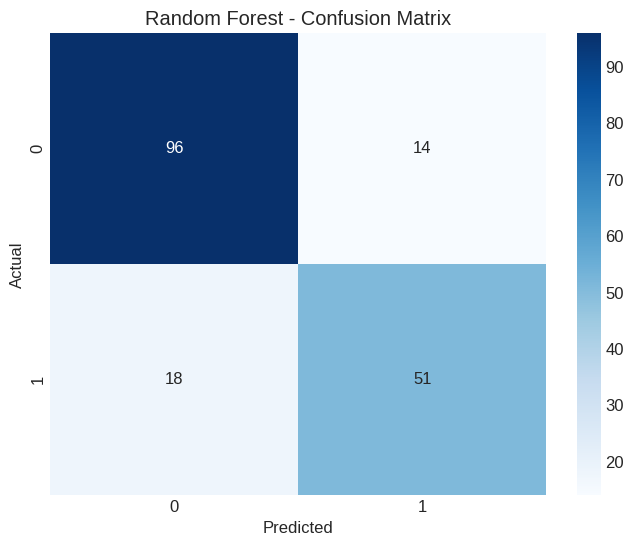


Training Gradient Boosting...
Gradient Boosting Accuracy: 0.8212
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.86       110
           1       0.78      0.75      0.76        69

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



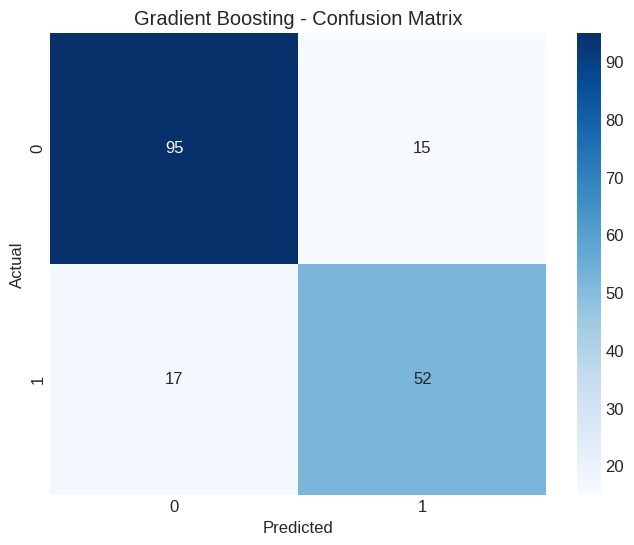


Training SVM...
SVM Accuracy: 0.8324
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.87       110
           1       0.81      0.74      0.77        69

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



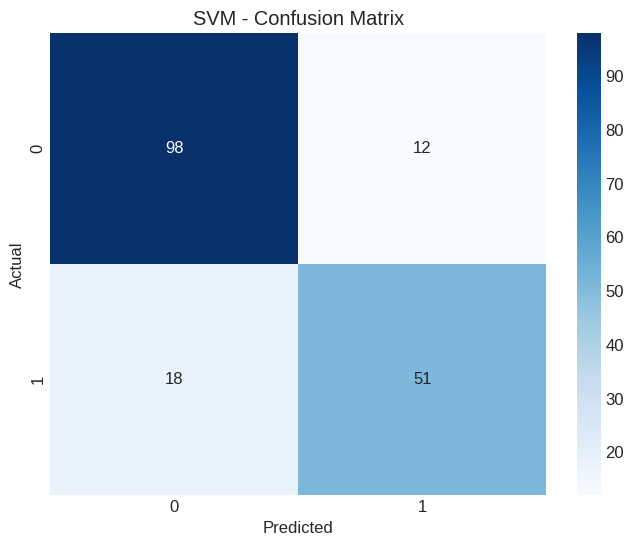


Training XGBoost...
XGBoost Accuracy: 0.8101
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       110
           1       0.79      0.70      0.74        69

    accuracy                           0.81       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.81      0.81      0.81       179



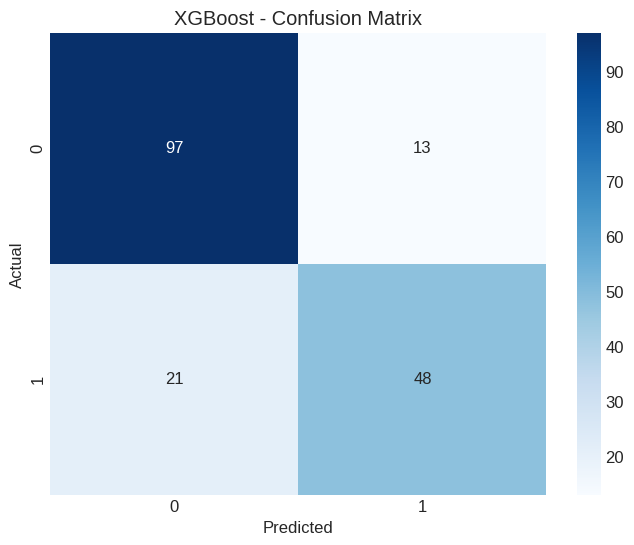


Training Logistic Regression...
Logistic Regression Accuracy: 0.8268
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       110
           1       0.82      0.71      0.76        69

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.83      0.83      0.82       179



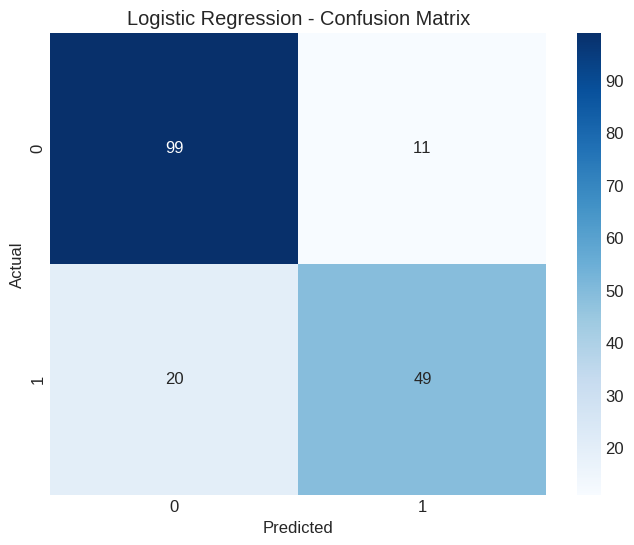


Training Neural Network...
Neural Network Accuracy: 0.7933
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       110
           1       0.74      0.71      0.73        69

    accuracy                           0.79       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



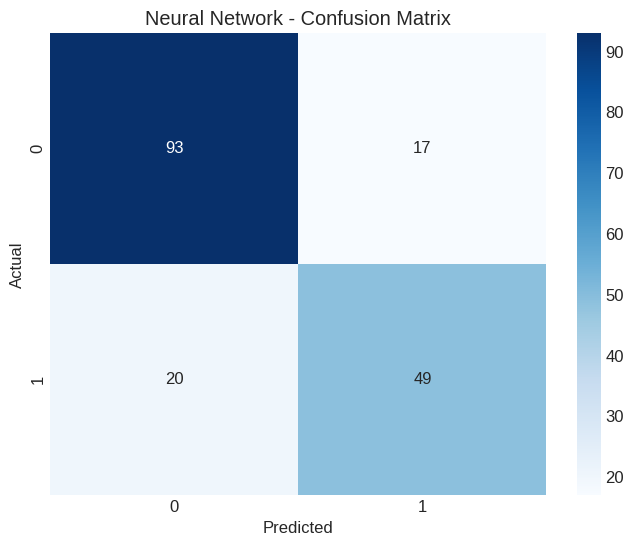


Training Voting Classifier...
Voting Classifier Accuracy: 0.8492
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       110
           1       0.82      0.78      0.80        69

    accuracy                           0.85       179
   macro avg       0.84      0.84      0.84       179
weighted avg       0.85      0.85      0.85       179



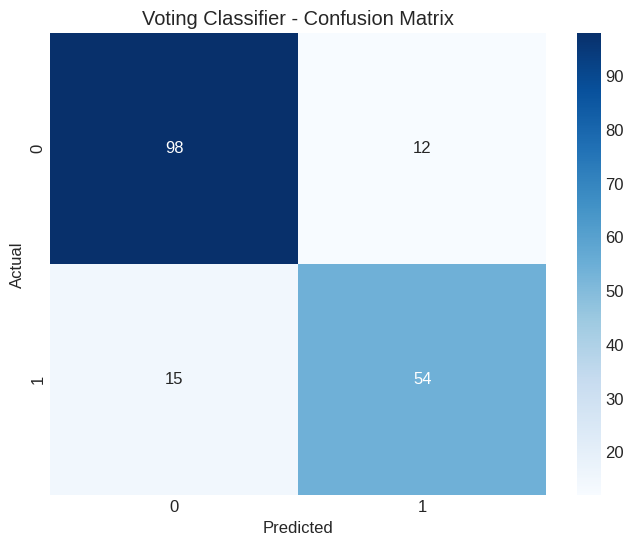


Training Stacking Classifier...
Stacking Classifier Accuracy: 0.8380
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.90      0.87       110
           1       0.82      0.74      0.78        69

    accuracy                           0.84       179
   macro avg       0.83      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179



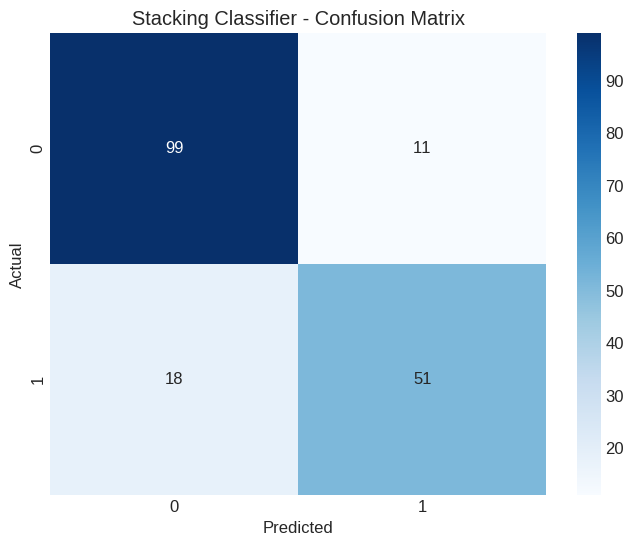


Best Model: Voting Classifier with accuracy 0.8492


In [41]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns  # Added missing import for seaborn

# Define models for ensemble
def create_models():
    # Base models
    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='sqrt',
        bootstrap=True,
        random_state=42
    )

    gb = GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=3,
        min_samples_split=2,
        min_samples_leaf=1,
        subsample=0.8,
        random_state=42
    )

    svm = SVC(
        C=1.0,
        kernel='rbf',
        gamma='scale',
        probability=True,
        random_state=42
    )

    xgb = XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

    lr = LogisticRegression(
        C=1.0,
        penalty='l2',
        solver='liblinear',
        random_state=42
    )

    mlp = MLPClassifier(
        hidden_layer_sizes=(100, 50),
        activation='relu',
        solver='adam',
        alpha=0.0001,
        batch_size='auto',
        learning_rate='adaptive',
        max_iter=500,
        random_state=42
    )

    # Voting Classifier
    voting_clf = VotingClassifier(
        estimators=[
            ('rf', rf),
            ('gb', gb),
            ('svm', svm),
            ('xgb', xgb),
            ('lr', lr)
        ],
        voting='soft'
    )

    # Stacking Classifier
    stacking_clf = StackingClassifier(
        estimators=[
            ('rf', rf),
            ('gb', gb),
            ('svm', svm),
            ('xgb', xgb),
            ('mlp', mlp)
        ],
        final_estimator=LogisticRegression(random_state=42)
    )

    return {
        'Random Forest': rf,
        'Gradient Boosting': gb,
        'SVM': svm,
        'XGBoost': xgb,
        'Logistic Regression': lr,
        'Neural Network': mlp,
        'Voting Classifier': voting_clf,
        'Stacking Classifier': stacking_clf
    }

# Create models
models = create_models()

# Train and evaluate models
def train_and_evaluate(models, X_train, X_test, y_train, y_test):
    results = {}

    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        results[name] = accuracy

        print(f"{name} Accuracy: {accuracy:.4f}")
        print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{name} - Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    return results

# Train and evaluate models
results = train_and_evaluate(models, X_train, X_test, y_train, y_test)

# Find the best model
best_model_name = max(results, key=results.get)
best_accuracy = results[best_model_name]
print(f"\nBest Model: {best_model_name} with accuracy {best_accuracy:.4f}")

In [42]:
# Cross-validation for the best model
best_model = models[best_model_name]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X_selected, y, cv=cv, scoring='accuracy')
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f}")

# Feature importance for the best model (if applicable)
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Get selected feature names
    selected_feature_names = [feature_names[i] for i in selected_indices]

    plt.figure(figsize=(12, 8))
    plt.title('Feature Importances')
    plt.bar(range(len(selected_feature_names)), importances[indices], align='center')
    plt.xticks(range(len(selected_feature_names)), [selected_feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

Cross-validation scores: [0.8603352  0.84831461 0.83707865 0.84269663 0.85955056]
Mean CV accuracy: 0.8496


# 6.1 Visualaization With The New Dataset and Features

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for our plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [52]:
# Load the processed dataset
# If you've already loaded the dataset earlier in your notebook, you can skip this step
df = pd.read_csv('/content/titanic_data/train.csv')

# Display the first few rows to understand the structure
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [53]:
# Create a copy of the dataset for feature engineering
df_processed = df.copy()

# Feature Engineering
# 1. Create a FamilySize feature
df_processed['FamilySize'] = df_processed['SibSp'] + df_processed['Parch'] + 1

# 2. Create IsAlone feature
df_processed['IsAlone'] = (df_processed['FamilySize'] == 1).astype(int)

# 3. Extract titles from names
df_processed['Title'] = df_processed['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# 4. Group rare titles
title_mapping = {
    'Mr': 'Mr',
    'Miss': 'Miss',
    'Mrs': 'Mrs',
    'Master': 'Master',
    'Dr': 'Rare',
    'Rev': 'Rare',
    'Col': 'Rare',
    'Major': 'Rare',
    'Mlle': 'Miss',
    'Countess': 'Rare',
    'Ms': 'Miss',
    'Lady': 'Rare',
    'Jonkheer': 'Rare',
    'Don': 'Rare',
    'Dona': 'Rare',
    'Mme': 'Mrs',
    'Capt': 'Rare',
    'Sir': 'Rare'
}
df_processed['Title'] = df_processed['Title'].map(title_mapping)
df_processed['Title'] = df_processed['Title'].fillna('Rare')

# 5. Fill missing Age values based on Title
df_processed['Age'] = df_processed.groupby('Title')['Age'].transform(lambda x: x.fillna(x.median()))

# 6. Create Age groups
df_processed['AgeGroup'] = pd.cut(df_processed['Age'],
                                 bins=[0, 12, 18, 35, 60, 100],
                                 labels=['Child', 'Teenager', 'Young Adult', 'Adult', 'Senior'])

# 7. Fill missing Embarked values
df_processed['Embarked'] = df_processed['Embarked'].fillna(df_processed['Embarked'].mode()[0])

# 8. Create Fare groups
df_processed['FareGroup'] = pd.qcut(df_processed['Fare'], 4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])

# 9. Create Cabin indicator (has cabin or not)
df_processed['HasCabin'] = df_processed['Cabin'].notna().astype(int)

# 10. Create Deck feature from Cabin
df_processed['Deck'] = df_processed['Cabin'].str[0].fillna('U')

# Display the processed dataset
df_processed.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone,Title,AgeGroup,FareGroup,HasCabin,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,0,Mr,Young Adult,Low,0,U
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,0,Mrs,Adult,High,1,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1,Miss,Young Adult,Medium-Low,0,U
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,0,Mrs,Young Adult,High,1,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,1,Mr,Young Adult,Medium-Low,0,U


# 6.2 Visualizing Survival Rates by New Features

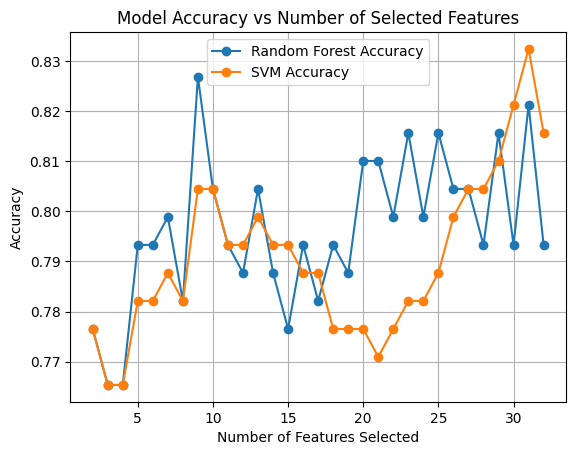

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

results = {}

# Try different numbers of top features
for k in range(2, X.shape[1]+1):
    selector = SelectKBest(score_func=f_classif, k=k)
    X_new = selector.fit_transform(X_scaled, y)

    # Split into train and test sets
    X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
        X_new, y, test_size=0.2, stratify=y, random_state=42
    )

    # Train RF
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train_new, y_train_new)
    rf_preds = rf.predict(X_test_new)
    rf_acc = accuracy_score(y_test_new, rf_preds)

    # Train SVM
    svm = SVC(random_state=42)
    svm.fit(X_train_new, y_train_new)
    svm_preds = svm.predict(X_test_new)
    svm_acc = accuracy_score(y_test_new, svm_preds)

    results[k] = {
        "Random Forest Accuracy": rf_acc,
        "SVM Accuracy": svm_acc
    }

# Convert to DataFrame for plotting
res_df = pd.DataFrame(results).T
res_df.plot(marker='o')
plt.title("Model Accuracy vs Number of Selected Features")
plt.xlabel("Number of Features Selected")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


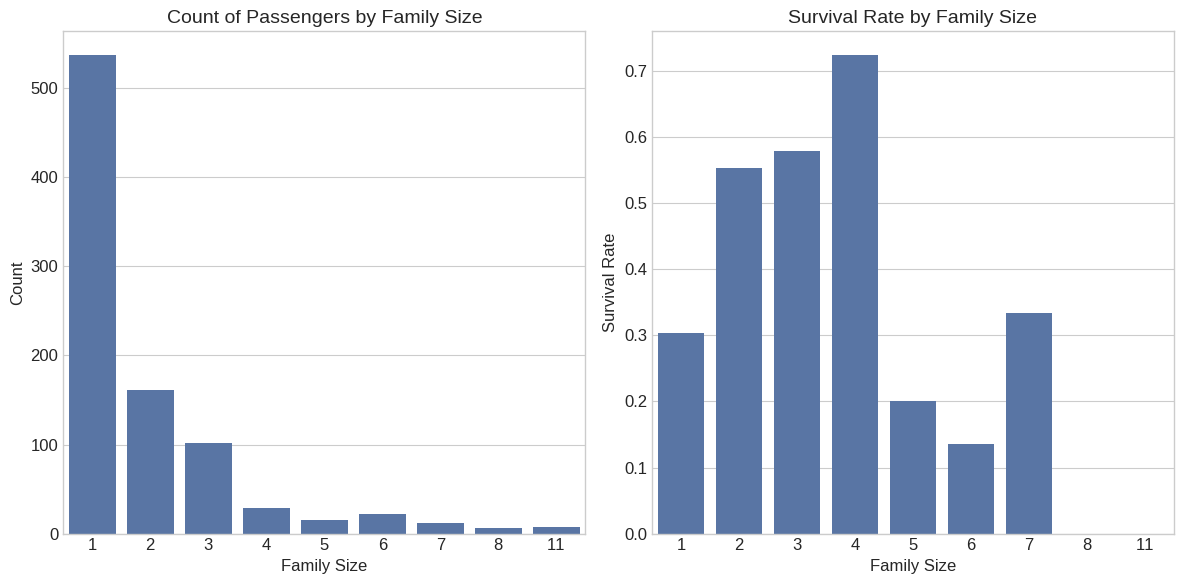

In [44]:
# 1. Survival Rate by Family Size
plt.figure(figsize=(12, 6))

# Count plot of Family Size
plt.subplot(1, 2, 1)
sns.countplot(x='FamilySize', data=df_processed)
plt.title('Count of Passengers by Family Size', fontsize=14)
plt.xlabel('Family Size', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Survival rate by Family Size
plt.subplot(1, 2, 2)
survival_rate = df_processed.groupby('FamilySize')['Survived'].mean()
sns.barplot(x=survival_rate.index, y=survival_rate.values)
plt.title('Survival Rate by Family Size', fontsize=14)
plt.xlabel('Family Size', fontsize=12)
plt.ylabel('Survival Rate', fontsize=12)

plt.tight_layout()
plt.show()

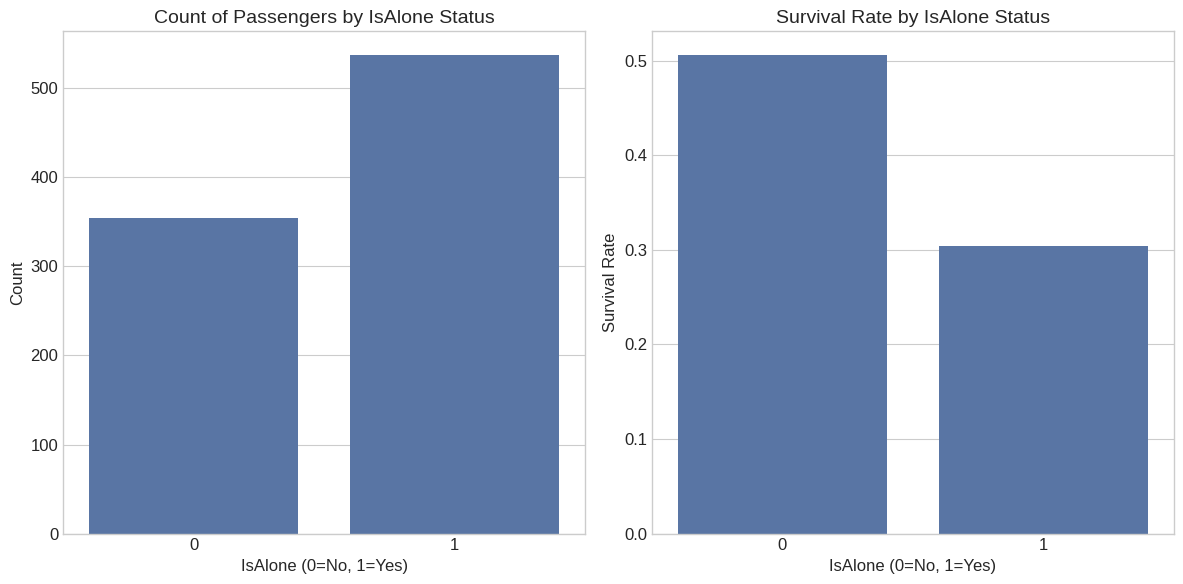

In [45]:
# 2. Survival Rate by IsAlone
plt.figure(figsize=(12, 6))

# Count plot of IsAlone
plt.subplot(1, 2, 1)
sns.countplot(x='IsAlone', data=df_processed)
plt.title('Count of Passengers by IsAlone Status', fontsize=14)
plt.xlabel('IsAlone (0=No, 1=Yes)', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Survival rate by IsAlone
plt.subplot(1, 2, 2)
survival_rate = df_processed.groupby('IsAlone')['Survived'].mean()
sns.barplot(x=survival_rate.index, y=survival_rate.values)
plt.title('Survival Rate by IsAlone Status', fontsize=14)
plt.xlabel('IsAlone (0=No, 1=Yes)', fontsize=12)
plt.ylabel('Survival Rate', fontsize=12)

plt.tight_layout()
plt.show()

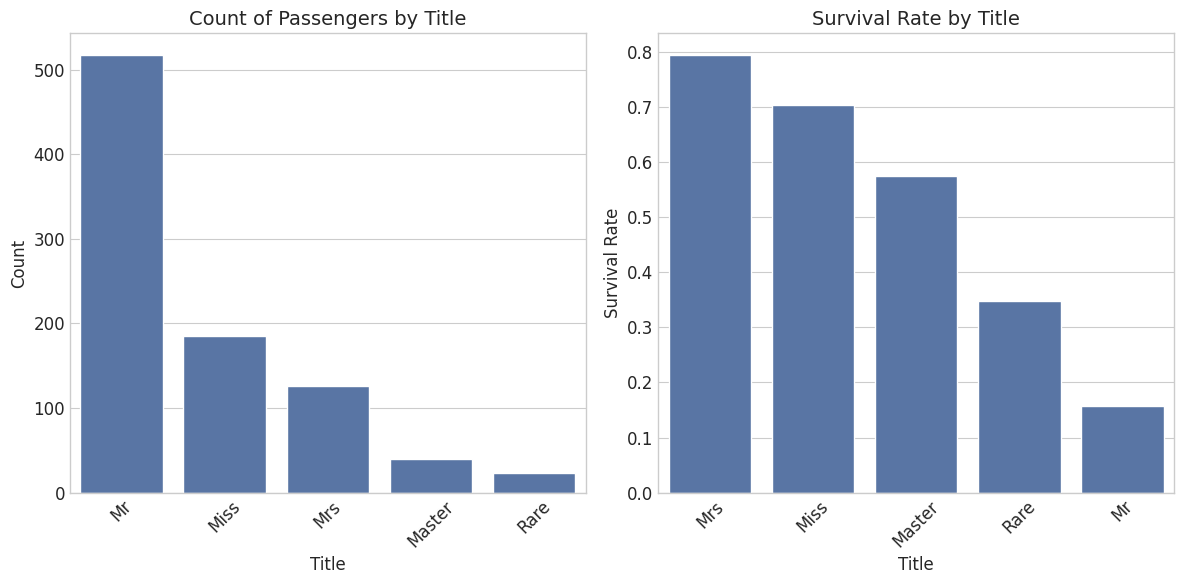

In [54]:
# 3. Survival Rate by Title
plt.figure(figsize=(12, 6))

# Count plot of Title
plt.subplot(1, 2, 1)
title_counts = df_processed['Title'].value_counts()
sns.barplot(x=title_counts.index, y=title_counts.values)
plt.title('Count of Passengers by Title', fontsize=14)
plt.xlabel('Title', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)

# Survival rate by Title
plt.subplot(1, 2, 2)
survival_rate = df_processed.groupby('Title')['Survived'].mean().sort_values(ascending=False)
sns.barplot(x=survival_rate.index, y=survival_rate.values)
plt.title('Survival Rate by Title', fontsize=14)
plt.xlabel('Title', fontsize=12)
plt.ylabel('Survival Rate', fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

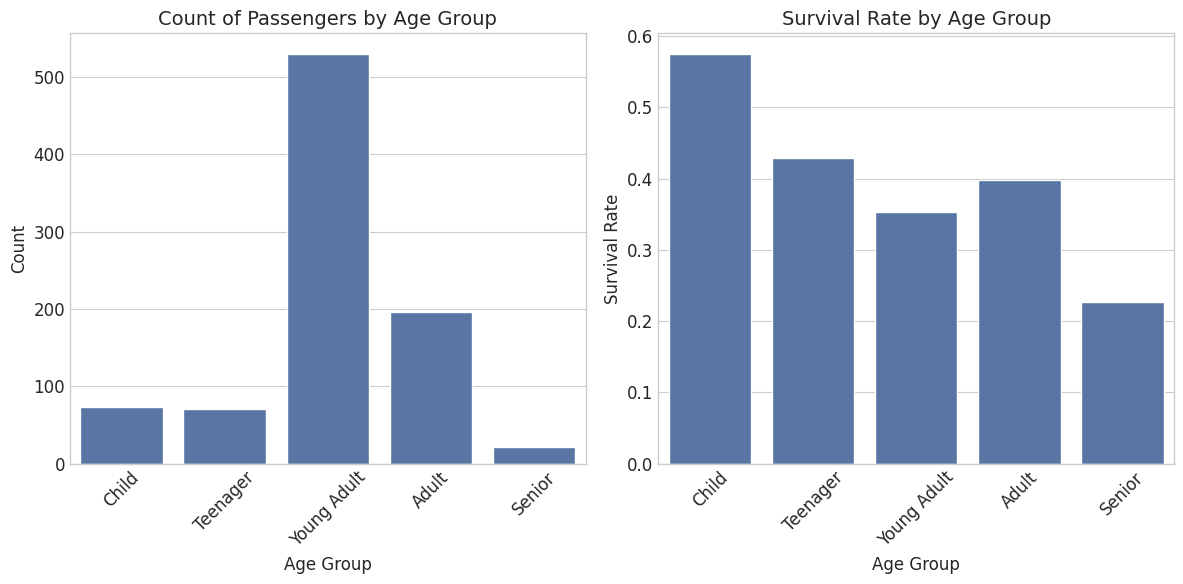

In [55]:
# 4. Survival Rate by Age Group
plt.figure(figsize=(12, 6))

# Count plot of Age Group
plt.subplot(1, 2, 1)
sns.countplot(x='AgeGroup', data=df_processed, order=['Child', 'Teenager', 'Young Adult', 'Adult', 'Senior'])
plt.title('Count of Passengers by Age Group', fontsize=14)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)

# Survival rate by Age Group
plt.subplot(1, 2, 2)
survival_rate = df_processed.groupby('AgeGroup')['Survived'].mean()
sns.barplot(x=survival_rate.index, y=survival_rate.values, order=['Child', 'Teenager', 'Young Adult', 'Adult', 'Senior'])
plt.title('Survival Rate by Age Group', fontsize=14)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Survival Rate', fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

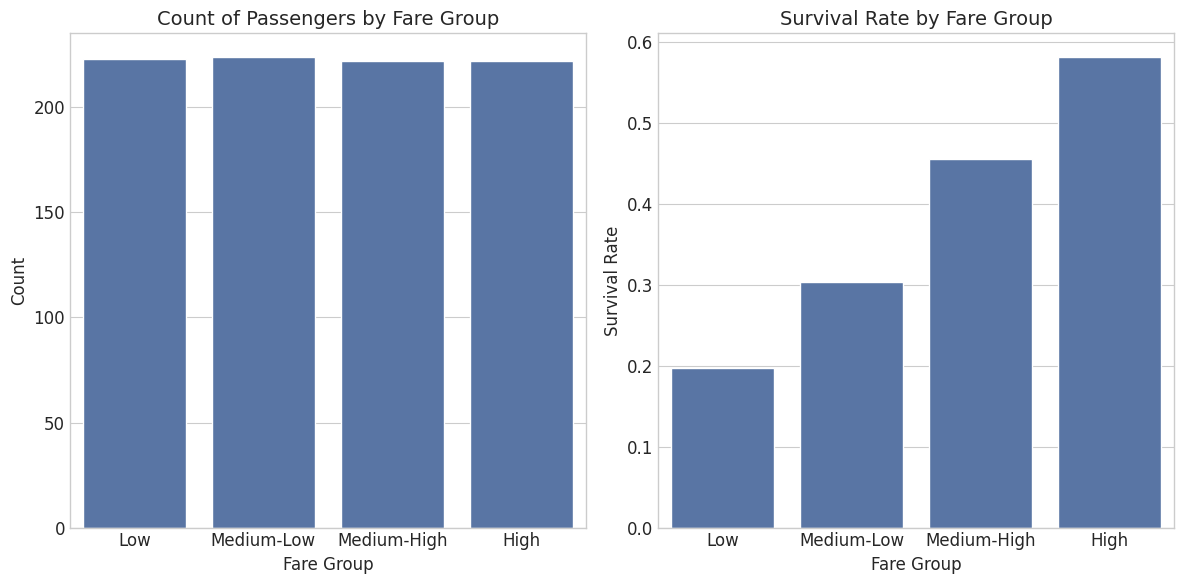

In [56]:
# 5. Survival Rate by Fare Group
plt.figure(figsize=(12, 6))

# Count plot of Fare Group
plt.subplot(1, 2, 1)
sns.countplot(x='FareGroup', data=df_processed, order=['Low', 'Medium-Low', 'Medium-High', 'High'])
plt.title('Count of Passengers by Fare Group', fontsize=14)
plt.xlabel('Fare Group', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Survival rate by Fare Group
plt.subplot(1, 2, 2)
survival_rate = df_processed.groupby('FareGroup')['Survived'].mean()
sns.barplot(x=survival_rate.index, y=survival_rate.values, order=['Low', 'Medium-Low', 'Medium-High', 'High'])
plt.title('Survival Rate by Fare Group', fontsize=14)
plt.xlabel('Fare Group', fontsize=12)
plt.ylabel('Survival Rate', fontsize=12)

plt.tight_layout()
plt.show()

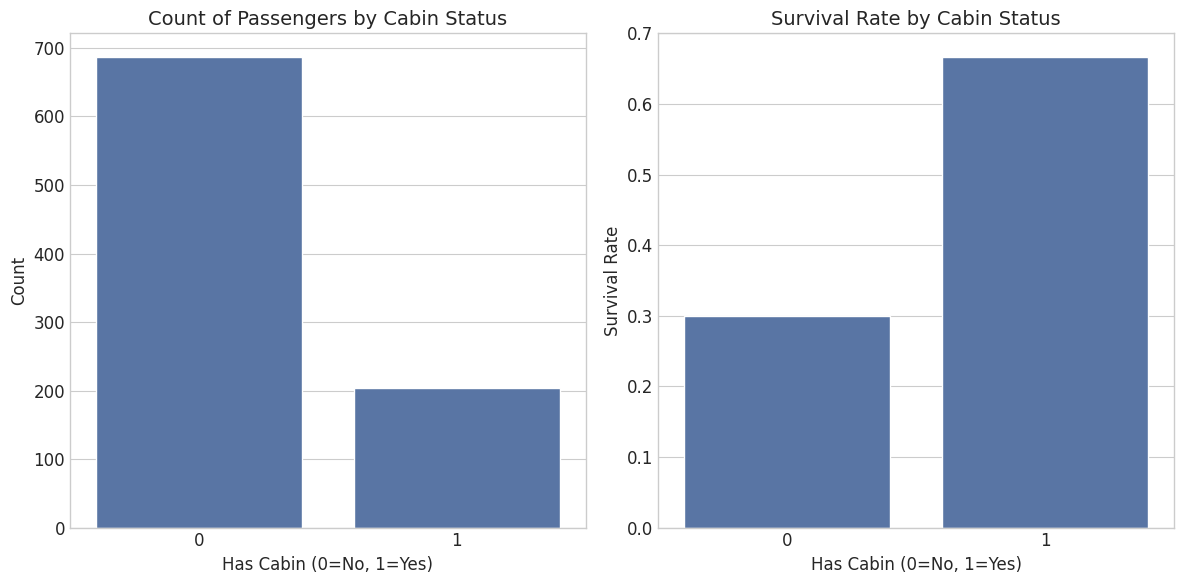

In [57]:
# 6. Survival Rate by HasCabin
plt.figure(figsize=(12, 6))

# Count plot of HasCabin
plt.subplot(1, 2, 1)
sns.countplot(x='HasCabin', data=df_processed)
plt.title('Count of Passengers by Cabin Status', fontsize=14)
plt.xlabel('Has Cabin (0=No, 1=Yes)', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Survival rate by HasCabin
plt.subplot(1, 2, 2)
survival_rate = df_processed.groupby('HasCabin')['Survived'].mean()
sns.barplot(x=survival_rate.index, y=survival_rate.values)
plt.title('Survival Rate by Cabin Status', fontsize=14)
plt.xlabel('Has Cabin (0=No, 1=Yes)', fontsize=12)
plt.ylabel('Survival Rate', fontsize=12)

plt.tight_layout()
plt.show()

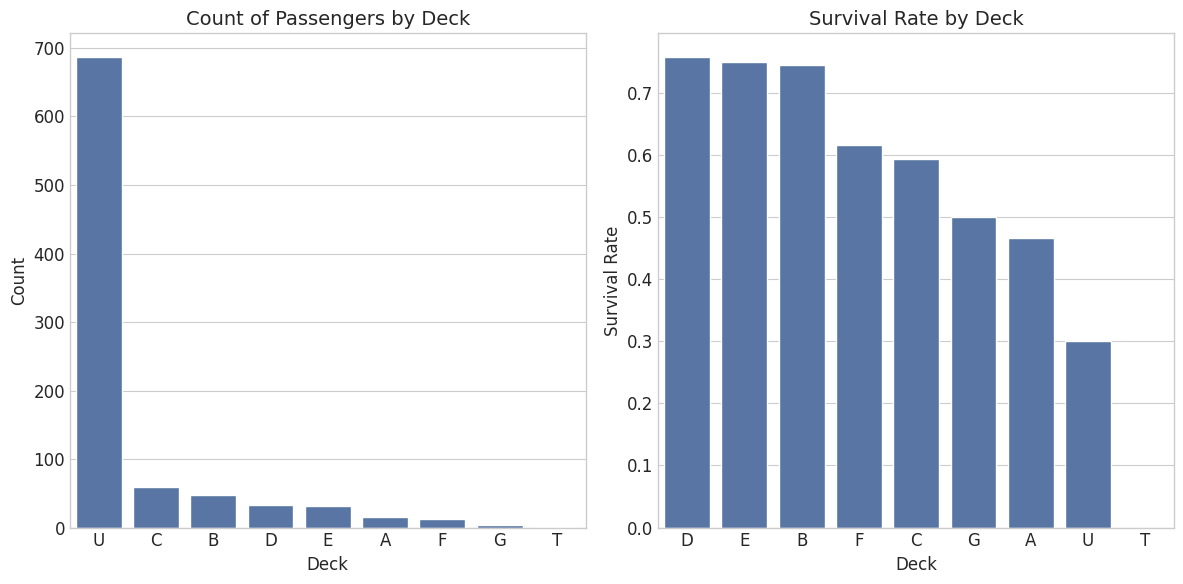

In [58]:
# 7. Survival Rate by Deck
plt.figure(figsize=(12, 6))

# Count plot of Deck
plt.subplot(1, 2, 1)
deck_counts = df_processed['Deck'].value_counts()
sns.barplot(x=deck_counts.index, y=deck_counts.values)
plt.title('Count of Passengers by Deck', fontsize=14)
plt.xlabel('Deck', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Survival rate by Deck
plt.subplot(1, 2, 2)
survival_rate = df_processed.groupby('Deck')['Survived'].mean().sort_values(ascending=False)
sns.barplot(x=survival_rate.index, y=survival_rate.values)
plt.title('Survival Rate by Deck', fontsize=14)
plt.xlabel('Deck', fontsize=12)
plt.ylabel('Survival Rate', fontsize=12)

plt.tight_layout()
plt.show()

# **6.3 Multivariate Analysis with New Features**

<Figure size 1200x600 with 0 Axes>

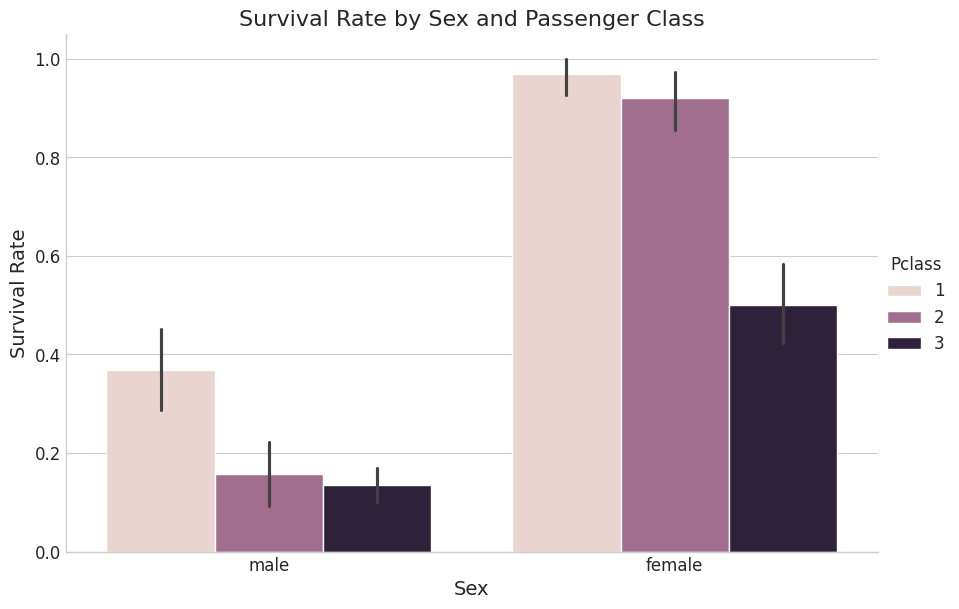

In [59]:
# 1. Survival Rate by Sex and Pclass
plt.figure(figsize=(12, 6))
sns.catplot(x='Sex', y='Survived', hue='Pclass', kind='bar', data=df_processed, height=6, aspect=1.5)
plt.title('Survival Rate by Sex and Passenger Class', fontsize=16)
plt.xlabel('Sex', fontsize=14)
plt.ylabel('Survival Rate', fontsize=14)
plt.show()

<Figure size 1200x600 with 0 Axes>

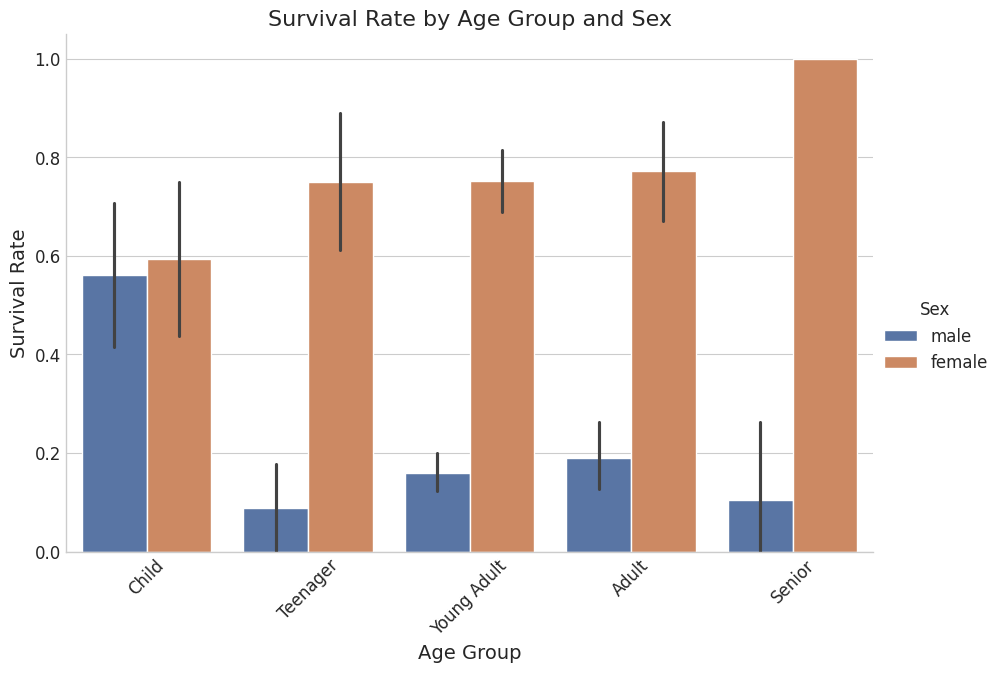

In [60]:
# 2. Survival Rate by AgeGroup and Sex
plt.figure(figsize=(12, 6))
sns.catplot(x='AgeGroup', y='Survived', hue='Sex', kind='bar', data=df_processed,
            order=['Child', 'Teenager', 'Young Adult', 'Adult', 'Senior'], height=6, aspect=1.5)
plt.title('Survival Rate by Age Group and Sex', fontsize=16)
plt.xlabel('Age Group', fontsize=14)
plt.ylabel('Survival Rate', fontsize=14)
plt.xticks(rotation=45)
plt.show()